In [1]:
#!kill 2128689
!nvidia-smi

Mon Sep 29 10:51:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
| 77%   66C    P2            335W /  450W |   18208MiB /  24564MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import sys
import os
import shutil
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
sys.path.append(os.path.abspath(".."))
from loader.Dataset import VideoDataset
from torch.utils.data import DataLoader
from models.transformers.encoders.vit_encoder import ViT
from models.transformers.decoders.vit_decoder import ViT_Decoder
from models.transformers.CustomTransformer import CustomizableTransformer
from utils.util import count_model_params, train_epoch, eval_model, train_model, load_model 
from matplotlib import pyplot as plt
from matplotlib import patches
import torch
from utils.util import l1_and_ssim_loss_function
from torch.utils.tensorboard import SummaryWriter
from utils.loss_function import ReconstructionLoss_PSNR_SSIM

%load_ext autoreload
%autoreload 2

#### configs

In [3]:
from loader.transforms import RGBNormalizer,Composition,CustomResize,RandomHorizontalFlip,RandomVerticalFlip,CustomColorJitter
original_number_of_frames_per_video=24

general_configs={
"data_path":"/home/nfs/inf6/data/datasets/MOVi/movi_c/",
"number_of_frames_per_video":24,
"max_objects_in_scene":11,
"batch_size":64,
"device" : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
"img_height":64,
"img_width":64,
"channels":3,
"learning_rate":3e-4,
"num_epochs":60,
"trainingMode":1 #0 training by bounding boxes, 1 training by masks. 
}

encoder_configs={
        "token_dim":128,
        "attn_dim":128,
        "num_heads":4,
        "mlp_size":512,
        "num_tf_layers":4
}
decoder_configs={
        "token_dim":128,
        "attn_dim":128,
        "num_heads":4,
        "mlp_size":512,
        "num_tf_layers":4
}

data_transform_config={
        "img_height":general_configs["img_height"],
        "img_width":general_configs["img_width"],
        "vFlip_probability":0.3,
        "hFlip_probability":0.3,
        "color_jitter_brightness":(0.8, 1.2),
        "color_jitter_hue":(-0.3, 0.3),
        "color_jitter_contrast":(0.6, 1.8),
        "color_jitter_saturation":(0.5, 1.5)
}

#### Datasets

In [4]:
transform_composition = Composition([
                                        RGBNormalizer(),
                                        CustomResize((data_transform_config["img_height"],data_transform_config["img_width"])),
                                        RandomVerticalFlip(data_transform_config["vFlip_probability"]),
                                        RandomHorizontalFlip(data_transform_config["hFlip_probability"]),
                                        #CustomColorJitter(
                                        #    brightness=data_transform_config["color_jitter_brightness"],
                                        #    hue=data_transform_config["color_jitter_hue"],
                                        #    contrast=data_transform_config["color_jitter_contrast"],
                                        #    saturation=data_transform_config["color_jitter_saturation"]
                                        #)
                                    ])
#transform_composition=None
validation_dataset = VideoDataset(data_path=general_configs["data_path"],
                            split='validation',
                            number_of_frames_per_video=general_configs["number_of_frames_per_video"],
                            max_objects_in_scene=general_configs["max_objects_in_scene"],
                            halve_dataset=True,
                            is_test_dataset=False,
                            transforms=transform_composition)
valid_loader = DataLoader(dataset=validation_dataset,
                            batch_size=general_configs["batch_size"],
                            shuffle=False,
                            drop_last=True)
train_dataset = VideoDataset(data_path=general_configs["data_path"],
                            split='train',
                            number_of_frames_per_video=general_configs["number_of_frames_per_video"],
                            max_objects_in_scene=general_configs["max_objects_in_scene"],
                            halve_dataset=False,
                            is_test_dataset=False,
                            transforms=transform_composition)
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=general_configs["batch_size"],
                            shuffle=True,
                            drop_last=True)

#### Datashapes

In [10]:
iterator=iter(train_loader)
coms,bboxes,masks,rgbs,flows=next(iterator)
print(f"shapes: \r\n{coms.shape=},\r\n{bboxes.shape=},\r\n{masks.shape=},\r\n{rgbs.shape=},\r\n{flows.shape=}\r\n============================================")
print(len(train_loader))

shapes: 
coms.shape=torch.Size([64, 24, 11, 2]),
bboxes.shape=torch.Size([64, 24, 11, 4]),
masks.shape=torch.Size([64, 24, 64, 64]),
rgbs.shape=torch.Size([64, 24, 3, 64, 64]),
flows.shape=torch.Size([64, 24, 3, 64, 64])
152


### Encoder

In [5]:
def defineVIT():
        return  ViT(
                img_height=general_configs["img_height"],
                img_width=general_configs["img_width"],
                channels=general_configs["channels"],
                max_objects_in_scene=general_configs["max_objects_in_scene"],
                frame_numbers=general_configs["number_of_frames_per_video"],
                token_dim=encoder_configs["token_dim"],
                attn_dim=encoder_configs["attn_dim"],
                num_heads=encoder_configs["num_heads"],
                mlp_size=encoder_configs["mlp_size"],
                num_tf_layers=encoder_configs["num_tf_layers"]).to(general_configs["device"])

In [6]:
vit=defineVIT()
print(f"ViT has {count_model_params(vit)} parameters")
vit

ViT has 2388736 parameters


ViT(
  (patch_projection): Sequential(
    (0): LayerNorm((12288,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=12288, out_features=128, bias=True)
  )
  (pos_emb): PositionalEncoding()
  (encoderBlocks): Sequential(
    (0): EncoderBlock(
      (ln_att): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (q): Linear(in_features=128, out_features=128, bias=False)
        (k): Linear(in_features=128, out_features=128, bias=False)
        (v): Linear(in_features=128, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ln_mlp): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
    (1): EncoderBlock(
      (ln_att):

### Decoder

In [7]:
def defineDecoder():
    return ViT_Decoder(
    batch_size=general_configs["batch_size"],
    img_height=general_configs["img_height"],
    img_width=general_configs["img_width"],
    channels=general_configs["channels"],
    frame_numbers=general_configs["number_of_frames_per_video"],
    token_dim=decoder_configs["token_dim"],
    attn_dim=decoder_configs["attn_dim"], 
    num_heads=decoder_configs["num_heads"], 
    mlp_size=decoder_configs["mlp_size"], 
    num_tf_layers=decoder_configs["num_tf_layers"],
    max_objects_in_scene=general_configs["max_objects_in_scene"],
    device=general_configs["device"]
).to(general_configs["device"])

In [8]:
decoder=defineDecoder()
print(f"Decoder has {count_model_params(decoder)} parameters")
decoder

Decoder has 1782016 parameters


ViT_Decoder(
  (patch_projection): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=128, out_features=12288, bias=True)
  )
  (pos_emb): PositionalEncoding()
)

### Transformer

In [9]:
transformer=CustomizableTransformer(encoder=vit, decoder=decoder).to(general_configs["device"])
assert count_model_params(decoder)+count_model_params(vit)==count_model_params(transformer)
print(f"transformer has {count_model_params(transformer)} parameters")
transformer

transformer has 4170752 parameters


CustomizableTransformer(
  (encoder): ViT(
    (patch_projection): Sequential(
      (0): LayerNorm((12288,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=12288, out_features=128, bias=True)
    )
    (pos_emb): PositionalEncoding()
    (encoderBlocks): Sequential(
      (0): EncoderBlock(
        (ln_att): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (q): Linear(in_features=128, out_features=128, bias=False)
          (k): Linear(in_features=128, out_features=128, bias=False)
          (v): Linear(in_features=128, out_features=128, bias=False)
          (out_proj): Linear(in_features=128, out_features=128, bias=False)
        )
        (ln_mlp): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (mlp): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=512, out_features=

#### Training

In [12]:
criterion=ReconstructionLoss_PSNR_SSIM(device=general_configs["device"],lambda_psnr=0.5,lambda_ssim=0.5)
optimizer = torch.optim.Adam(transformer.parameters(), lr=general_configs["learning_rate"])
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
TBOARD_LOGS = os.path.join(os.getcwd(), "../tboard_logs", "ViT_30")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [13]:
"""train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=transformer,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        train_loader=train_loader,
        valid_loader=valid_loader,
        num_epochs=general_configs["num_epochs"],
        tboard=writer,
        trainingmode=general_configs["trainingMode"],
        conf=(decoder_configs,encoder_configs,general_configs)    )

'train_loss, val_loss, loss_iters, valid_acc = train_model(\n        model=transformer,\n        optimizer=optimizer,\n        scheduler=scheduler,\n        criterion=criterion,\n        train_loader=train_loader,\n        valid_loader=valid_loader,\n        num_epochs=general_configs["num_epochs"],\n        tboard=writer,\n        trainingmode=general_configs["trainingMode"]    )\nfrom utils.util import save_model\nstats = {\n    "train_loss": train_loss,\n    "valid_loss": val_loss,\n    "loss_iters": loss_iters,\n    "valid_acc": valid_acc\n}\nsave_model(transformer, optimizer, epoch=general_configs["num_epochs"], stats=stats)'

In [14]:
from utils.util import device


stats = {
    "train_loss": [],
    "valid_loss": [],
    "loss_iters": [],
    "valid_acc": []
}
model, optimizer, epoch, stats = load_model(transformer, optimizer, savepath="../../checkpoints/checkpoint_epoch_60_PSNR_SSIM.pth")

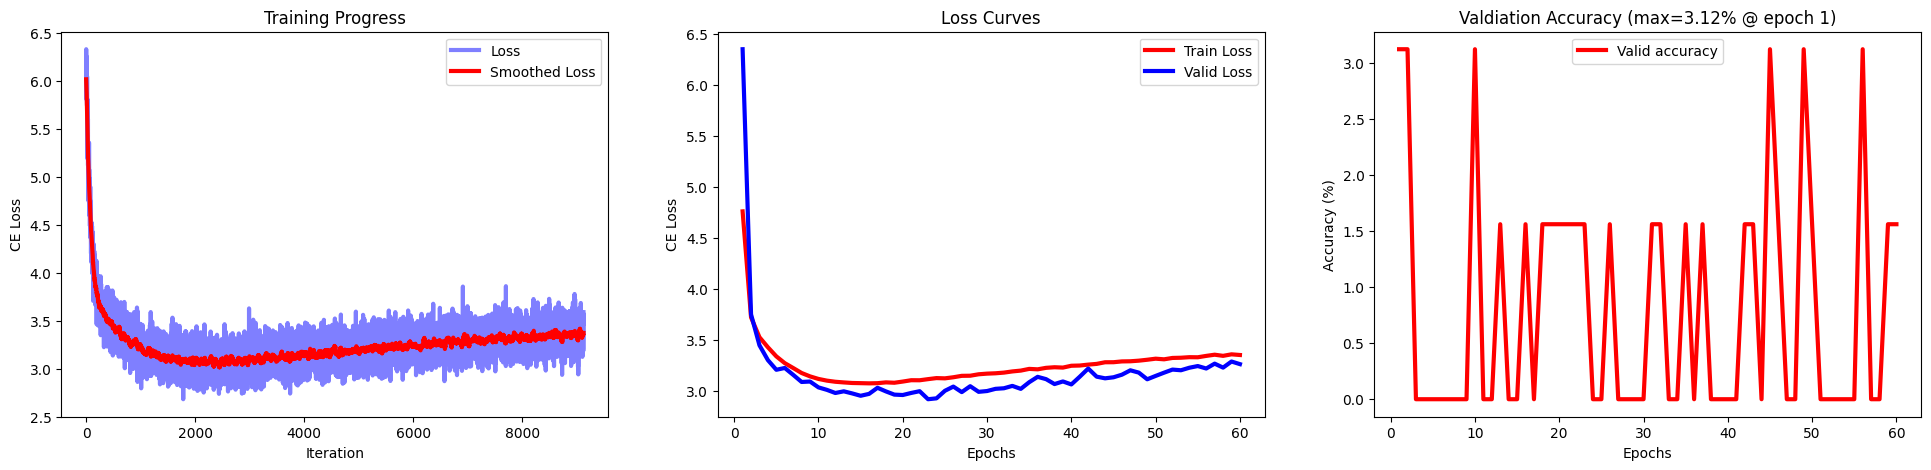

In [15]:
from utils.util import visualize_progress

loss_iters = stats['loss_iters']
val_loss = stats['valid_loss']
train_loss = stats['train_loss']
valid_acc = stats['valid_acc']

visualize_progress(loss_iters, train_loss, val_loss, valid_acc, start=0)
plt.show()

In [16]:
test_dataset = VideoDataset(data_path=general_configs["data_path"],
                            split='validation',
                            number_of_frames_per_video=general_configs["number_of_frames_per_video"],
                            max_objects_in_scene=general_configs["max_objects_in_scene"],
                            halve_dataset=True,
                            is_test_dataset=True,
                            transforms=transform_composition)
test_loader = DataLoader(dataset=test_dataset,
                            batch_size=general_configs["batch_size"],
                            shuffle=False,
                            drop_last=True)

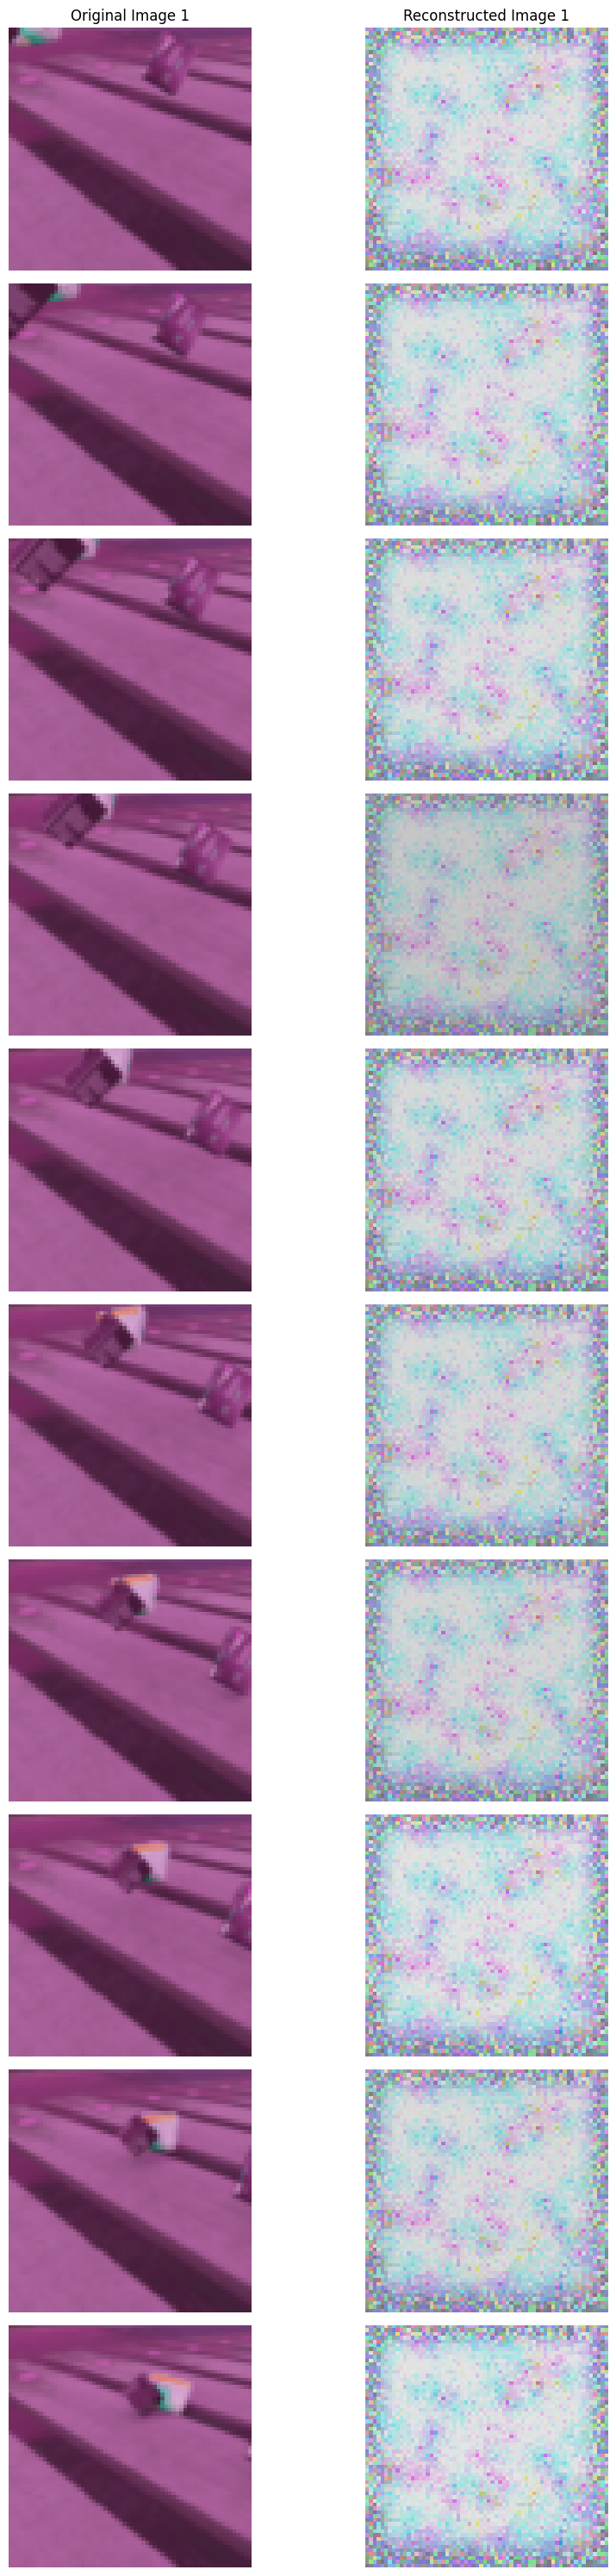

In [ ]:
import random


iterator=iter(test_loader)
coms,bboxes,masks,rgbs,flows=next(iterator)
transformer.eval()
with torch.no_grad():
   recons = transformer(rgbs.to(device),masks=masks.to(device)).to('cpu')

number_of_images=10
number_of_columns=2
video_index=random.randint(0,recons.shape[0])
fig, ax = plt.subplots(number_of_images,number_of_columns)
fig.set_size_inches(number_of_columns*5, number_of_images*3)

for i in range (number_of_images):
    for i in range(number_of_images):
        ax[i,1].imshow((recons[video_index,i]*255).clamp(0, 255).permute(1,2,0).byte().numpy())
        ax[i,1].axis("off")
        ax[i,0].imshow((rgbs[video_index,i]*255).clamp(0, 255).permute(1,2,0).byte().numpy())
        ax[i,0].axis("off")
        if i==0:
            ax[i,1].set_title(f"Reconstructed Image {i+1}")    
            ax[i,0].set_title(f"Original Image {i+1}")    


plt.tight_layout()
plt.show()